# 🧪 Lab Tutorial: Autoencoder

## 1. MNIST Dataset
- 10 digit classes (0–9)
- 60,000 training / 10,000 test samples
- 28×28 grayscale images, normalized to [0,1]

---

## 2. Autoencoder
- Encoder compresses data into a low-dimensional latent space, Decoder reconstructs the input
- Unsupervised training: the model automatically learns inherent patterns of the data (no specific task)

## 3. Latent Space Visualization
- **2D latent space** for visualization, plot latent vectors and color by digit label
- Similar digits form clusters even without labels (note that we do not provide class label information)

## 4. Transfer Learning (Feature Reuse)
- The encoder is pretrained in a fully unsupervised manner and reused as a fixed feature extractor
- Task-agnostic representations suitable for supervised downstream learning (classification problem)

## 5. Denoising Autoencoder
- Add noise to the input during training
- Train the model to reconstruct the clean image

In [38]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset


# local data folder
data_root = "./data"
os.makedirs(data_root, exist_ok=True)

transform = transforms.ToTensor()

# download train / test to local folder
train_ds = MNIST(root=data_root, train=True,  download=True, transform=transform)
test_ds  = MNIST(root=data_root, train=False, download=True, transform=transform)

print("Train samples:", len(train_ds))
print("Test samples :", len(test_ds))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False)


Train samples: 60000
Test samples : 10000


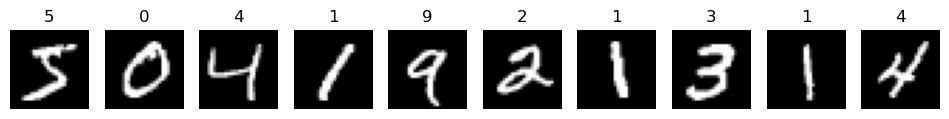

In [39]:
import matplotlib.pyplot as plt

n = 10
fig, axes = plt.subplots(1, n, figsize=(12, 2))
for i in range(n):
    img, label = train_ds[i]      # PIL → Tensor via transform
    axes[i].imshow(img.squeeze(0), cmap="gray")
    axes[i].set_title(str(label))
    axes[i].axis("off")
plt.show()


## AE with conv layer

### Autoencoder Architecture

This model is a **convolutional autoencoder** designed for 28×28 grayscale images (e.g., MNIST).

- **Encoder**
  - Three convolutional layers with ReLU activations and max pooling

- **Decoder**
  - A symmetric structure that reconstructs the image from the latent vector
  - Fully connected layer followed by upsampling and convolutional layers
  - Final sigmoid activation ensures output values in the range [0, 1]

- **Training Objective**
  - The model is trained to minimize reconstruction error

In [40]:
import torch
import torch.nn.functional as F
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Autoencoder model (as a single nn.Module) ----------
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)          # same
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)         # same
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)        # same
        self.pool  = nn.MaxPool2d(2, 2, ceil_mode=True)      # "same" pooling

        self.fc_e  = nn.Linear(128 * 4 * 4, 512)
        self.fc_z  = nn.Linear(512, latent_dim)

        self.fc_d  = nn.Linear(latent_dim, 128 * 4 * 4)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)       # same
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)        # same
        self.conv6 = nn.Conv2d(64, 32, 3)                    # valid (no padding)
        self.conv7 = nn.Conv2d(32, 1, 3, padding=1)          # same + sigmoid

        self.up = nn.Upsample(scale_factor=2, mode="nearest")# UpSampling2D

    def encode(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        z = self.fc_z(F.relu(self.fc_e(x)))
        return z

    def decode(self, z):
        x = F.relu(self.fc_d(z))
        x = x.view(z.size(0), 128, 4, 4)
        x = self.up(F.relu(self.conv4(x)))
        x = self.up(F.relu(self.conv5(x)))
        x = self.up(F.relu(self.conv6(x)))
        x_hat = torch.sigmoid(self.conv7(x))
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

# ---------- Instantiate ----------
ae = Autoencoder(latent_dim=2).to(device)

# sanity check
x = torch.randn(8, 1, 28, 28).to(device)
x_hat, z = ae(x)
print(x_hat.shape, z.shape)

torch.Size([8, 1, 28, 28]) torch.Size([8, 2])


In [41]:
import torch
import torch.nn as nn

# assumes you already have:
# - device
# - train_loader, test_loader
# - ae = Autoencoder(...).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

def train_one_epoch():
    ae.train()
    total_loss, n = 0.0, 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, _ = ae(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / n

@torch.no_grad()
def eval_one_epoch():
    ae.eval()
    total_loss, n = 0.0, 0
    for x, _ in test_loader:
        x = x.to(device)
        x_hat, _ = ae(x)
        loss = criterion(x_hat, x)
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / n

epochs = 15
for ep in range(1, epochs + 1):
    tr = train_one_epoch()
    te = eval_one_epoch()
    print(f"Epoch {ep:02d} | train loss {tr:.4f} | test loss {te:.4f}")


Epoch 01 | train loss 0.2229 | test loss 0.1947
Epoch 02 | train loss 0.1899 | test loss 0.1855
Epoch 03 | train loss 0.1835 | test loss 0.1814
Epoch 04 | train loss 0.1801 | test loss 0.1795
Epoch 05 | train loss 0.1781 | test loss 0.1768
Epoch 06 | train loss 0.1766 | test loss 0.1761
Epoch 07 | train loss 0.1755 | test loss 0.1755
Epoch 08 | train loss 0.1746 | test loss 0.1749
Epoch 09 | train loss 0.1735 | test loss 0.1734
Epoch 10 | train loss 0.1729 | test loss 0.1731
Epoch 11 | train loss 0.1719 | test loss 0.1720
Epoch 12 | train loss 0.1713 | test loss 0.1725
Epoch 13 | train loss 0.1709 | test loss 0.1715
Epoch 14 | train loss 0.1704 | test loss 0.1717
Epoch 15 | train loss 0.1696 | test loss 0.1717


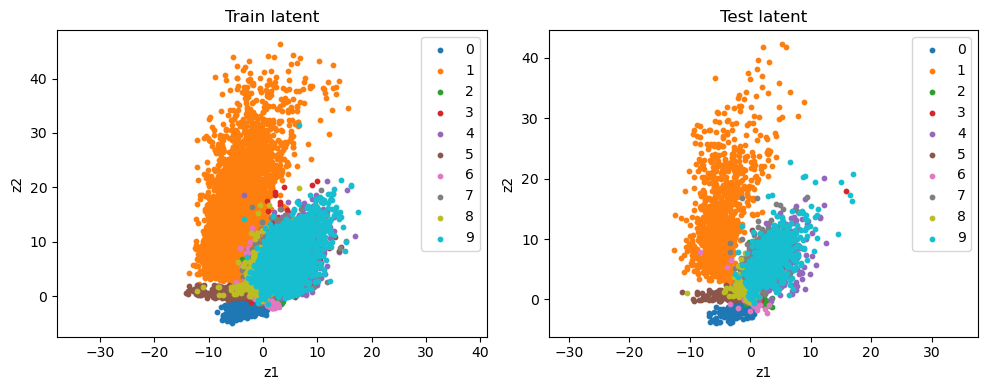

In [42]:
import matplotlib.pyplot as plt

ae.eval()

# -------- collect train --------
Z_tr, Y_tr = [], []
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, z = ae(x)          # z: (B, 2)
        Z_tr.append(z.cpu())
        Y_tr.append(y)

Z_tr = torch.cat(Z_tr).numpy()
Y_tr = torch.cat(Y_tr).numpy()

# -------- collect test --------
Z_te, Y_te = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, z = ae(x)
        Z_te.append(z.cpu())
        Y_te.append(y)

Z_te = torch.cat(Z_te).numpy()
Y_te = torch.cat(Y_te).numpy()

# -------- plot --------
plt.figure(figsize=(10, 4))

# Train
plt.subplot(1, 2, 1)
for c in set(Y_tr):
    idx = (Y_tr == c)
    plt.scatter(Z_tr[idx, 0], Z_tr[idx, 1], s=10, label=str(c))
plt.title("Train latent")
plt.xlabel("z1"); plt.ylabel("z2")
plt.axis("equal")
plt.legend()

# Test
plt.subplot(1, 2, 2)
for c in set(Y_te):
    idx = (Y_te == c)
    plt.scatter(Z_te[idx, 0], Z_te[idx, 1], s=10, label=str(c))
plt.title("Test latent")
plt.xlabel("z1"); plt.ylabel("z2")
plt.axis("equal")
plt.legend()

plt.tight_layout()
plt.show()

# outlier detector


- The spontaneous clustering observed in the latent space reflects the model’s ability to uncover the underlying structure of the data without any explicit supervision.
- From an AI perspective, this suggests that meaningful concepts (such as digit identity) are not imposed by labels, but emerge naturally from the statistical regularities of the data itself.
- Outlier detectoin, augmentation

=================================
### Transfer Learning with a Frozen Autoencoder Encoder

This code evaluates the quality of representations learned by the autoencoder encoder.

- The pretrained autoencoder is **fully frozen**, and only a lightweight classifier is trained (1 linear layer).
- Features are extracted from the **pre-latent layer (512-dimensional)**, before the severe dimensional bottleneck.
- By training a simple linear classifier on top of these fixed features, we assess whether the unsupervised encoder has learned discriminative and transferable representations.

High classification accuracy indicates that:
- the encoder captures meaningful, task-relevant structure in the data,
- unsupervised learning alone can produce strong features for supervised downstream tasks.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1) freeze AE 
ae.eval()
for p in ae.parameters():
    p.requires_grad = False

# 2) classifier head (512 -> 10)
clf = nn.Linear(512, 10).to(device)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.Adam(clf.parameters(), lr=1e-3)

def get_h_pre_z(x):
    x = ae.pool(F.relu(ae.conv1(x)))
    x = ae.pool(F.relu(ae.conv2(x)))
    x = ae.pool(F.relu(ae.conv3(x)))
    x = x.view(x.size(0), -1)
    h = F.relu(ae.fc_e(x))     # (B, 512)  
    return h

def train_one_epoch_cls():
    clf.train()
    total_correct, total_n, total_loss = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()

        with torch.no_grad():
            h = get_h_pre_z(x)        # (B,512) frozen feature

        logits = clf(h)
        loss = crit(logits, y)
        loss.backward()
        opt.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss/total_n, total_correct/total_n

@torch.no_grad()
def eval_one_epoch_cls():
    clf.eval()
    total_correct, total_n, total_loss = 0, 0, 0.0

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        h = get_h_pre_z(x)
        logits = clf(h)
        loss = crit(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss/total_n, total_correct/total_n

for ep in range(1, 11):
    trL, trA = train_one_epoch_cls()
    teL, teA = eval_one_epoch_cls()
    print(f"[CLS@512] Epoch {ep:02d} | train acc {trA*100:.2f}% | test acc {teA*100:.2f}%")


[CLS@512] Epoch 01 | train acc 82.31% | test acc 90.10%
[CLS@512] Epoch 02 | train acc 90.92% | test acc 92.28%
[CLS@512] Epoch 03 | train acc 92.23% | test acc 93.05%
[CLS@512] Epoch 04 | train acc 92.92% | test acc 93.71%
[CLS@512] Epoch 05 | train acc 93.41% | test acc 93.97%
[CLS@512] Epoch 06 | train acc 93.73% | test acc 94.10%
[CLS@512] Epoch 07 | train acc 93.98% | test acc 94.42%
[CLS@512] Epoch 08 | train acc 94.27% | test acc 94.55%
[CLS@512] Epoch 09 | train acc 94.43% | test acc 94.69%
[CLS@512] Epoch 10 | train acc 94.57% | test acc 94.90%


### Denoising Autoencoder

In a denoising autoencoder, random noise is added to the input during training, while the target remains the clean image.

- The model learns to reconstruct the original input from a corrupted version.
- This forces the encoder to capture **robust and noise-invariant features**, rather than memorizing pixel-level details.
- As a result, the learned representation becomes more stable and generalizable to unseen or noisy data.

In [ ]:

# assumes you already have:
# - train_loader, test_loader

# =========================
# 2) Denoising AE instance
# =========================
ae_denoising = Autoencoder(latent_dim=2).to(device)

# =========================
# 3) Loss / Optimizer
# =========================
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(ae_denoising.parameters(), lr=1e-3)

# =========================
# 4) Noise function
# =========================
noise_std = 0.4  # 0.2~0.5 

def add_noise(x, std=noise_std):
    x_noisy = x + std * torch.randn_like(x)
    x_noisy = torch.clamp(x_noisy, 0.0, 1.0)
    return x_noisy

# =========================
# 5) Train / Eval
# =========================
def train_one_epoch_dae():
    ae_denoising.train()
    total_loss, n = 0.0, 0

    for x, _ in train_loader:
        x = x.to(device)           # clean target
        x_noisy = add_noise(x)     # noisy input

        optimizer.zero_grad()
        x_hat, _ = ae_denoising(x_noisy)
        loss = criterion(x_hat, x) # denoise: noisy -> clean
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        n += x.size(0)

    return total_loss / n

@torch.no_grad()
def eval_one_epoch_dae():
    ae_denoising.eval()
    total_loss, n = 0.0, 0

    for x, _ in test_loader:
        x = x.to(device)
        x_noisy = add_noise(x)

        x_hat, _ = ae_denoising(x_noisy)
        loss = criterion(x_hat, x)

        total_loss += loss.item() * x.size(0)
        n += x.size(0)

    return total_loss / n

# =========================
# 6) Run
# =========================
epochs = 8
for ep in range(1, epochs + 1):
    tr = train_one_epoch_dae()
    te = eval_one_epoch_dae()
    print(f"[DAE] Epoch {ep:02d} | train loss {tr:.4f} | test loss {te:.4f}")


[DAE] Epoch 01 | train loss 0.2407 | test loss 0.2035
[DAE] Epoch 02 | train loss 0.1975 | test loss 0.1928
[DAE] Epoch 03 | train loss 0.1897 | test loss 0.1869
[DAE] Epoch 04 | train loss 0.1856 | test loss 0.1846
[DAE] Epoch 05 | train loss 0.1831 | test loss 0.1839
[DAE] Epoch 06 | train loss 0.1814 | test loss 0.1802
[DAE] Epoch 07 | train loss 0.1799 | test loss 0.1796
[DAE] Epoch 08 | train loss 0.1784 | test loss 0.1786


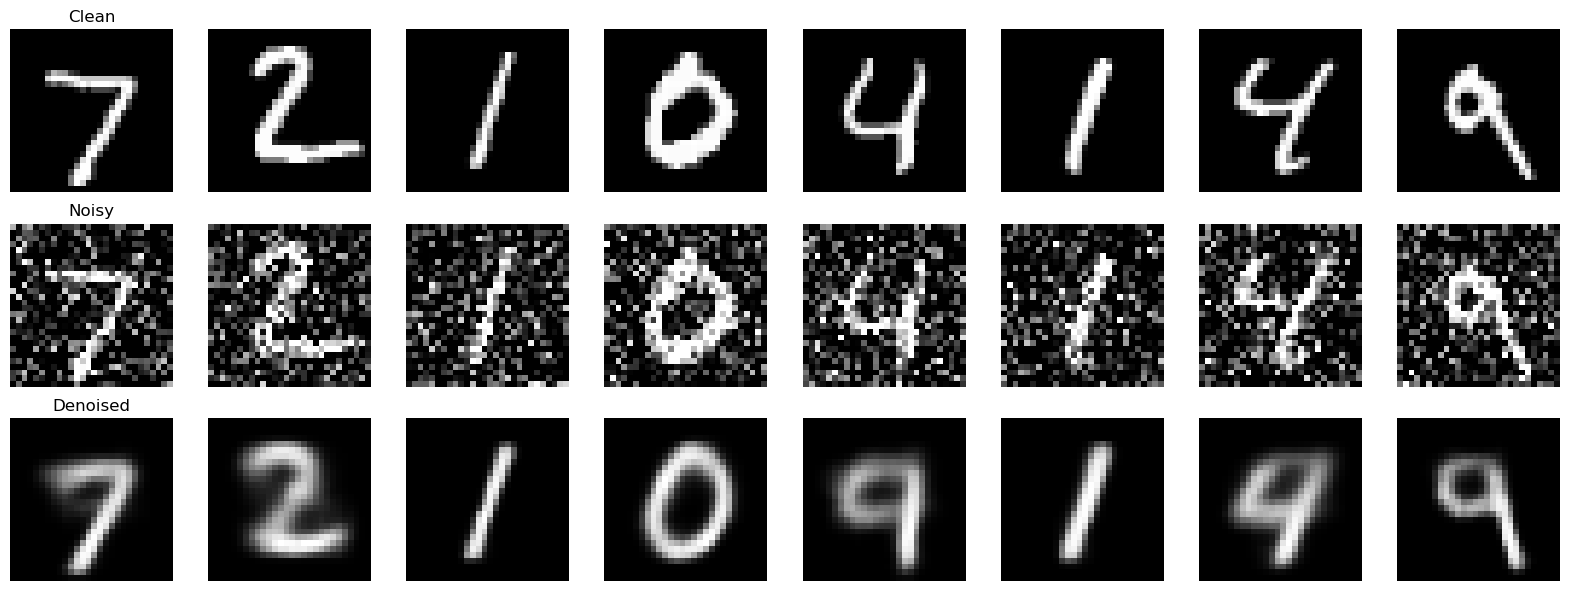

In [ ]:
import matplotlib.pyplot as plt
import torch

# assumes you already have:
# - device
# - test_loader
# - ae_denoising (trained)
# - add_noise(x) already defined

ae_denoising.eval()

# 1) test -> 8 images
x, y = next(iter(test_loader))
x = x[:8].to(device)

# 2) noise function corruption
x_noisy = add_noise(x)

# 3) denoising inference
with torch.no_grad():
    x_out, _ = ae_denoising(x_noisy)

# 4) cpu로
x_clean = x.detach().cpu()
x_noisy = x_noisy.detach().cpu()
x_out   = x_out.detach().cpu()

# 5) visualize: clean / noisy / output
N = 8
plt.figure(figsize=(2*N, 6))

# row 1: clean
for i in range(N):
    plt.subplot(3, N, i + 1)
    plt.imshow(x_clean[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Clean")

# row 2: noisy
for i in range(N):
    plt.subplot(3, N, N + i + 1)
    plt.imshow(x_noisy[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Noisy")

# row 3: denoised
for i in range(N):
    plt.subplot(3, N, 2*N + i + 1)
    plt.imshow(x_out[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Denoised")

plt.tight_layout()
plt.show()


==========================================================

# Homework: Autoencoder on Fashion-MNIST

Using the **Fashion-MNIST** dataset, complete the following tasks.

---

## 1. Autoencoder Training
- Design a convolutional autoencoder.
- Train the autoencoder using the Fashion-MNIST training set.
- Use only reconstruction loss (unsupervised learning).

---

## 2. Latent Space Visualization
- Extract latent representations from the trained autoencoder.
- Visualize the latent space (e.g., 2D) with each class color-coded.
- Analyze how different clothing categories are organized in the latent space.

---

## 3. Transfer Learning with Frozen Encoder
- Freeze the pretrained encoder.
- Attach a **trainable classifier head** (single linear layer).
- Train the classifier using class labels.
- Report classification performance on the test set.

---

## 4. Fine-Tuning the Entire Model
- Unfreeze the encoder (backbone).
- Train the entire architecture end-to-end with a **smaller learning rate**.
- Compare the performance before and after fine-tuning.

In [ ]:
# =============================================
# HOMEWORK: Fashion-MNIST Autoencoder
# =============================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data folder
data_root = "./data"
os.makedirs(data_root, exist_ok=True)

transform = transforms.ToTensor()

# Download Fashion-MNIST
train_ds_fashion = FashionMNIST(root=data_root, train=True,  download=True, transform=transform)
test_ds_fashion  = FashionMNIST(root=data_root, train=False, download=True, transform=transform)

print("Train samples:", len(train_ds_fashion))
print("Test samples :", len(test_ds_fashion))

# DataLoaders
train_loader_fashion = DataLoader(train_ds_fashion, batch_size=128, shuffle=True)
test_loader_fashion  = DataLoader(test_ds_fashion,  batch_size=128, shuffle=False)

# Fashion-MNIST class names
fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Visualize some Fashion-MNIST samples
n = 10
fig, axes = plt.subplots(1, n, figsize=(14, 2))
for i in range(n):
    img, label = train_ds_fashion[i]
    axes[i].imshow(img.squeeze(0), cmap="gray")
    axes[i].set_title(fashion_labels[label], fontsize=8)
    axes[i].axis("off")
plt.suptitle("Fashion-MNIST Samples")
plt.tight_layout()
plt.show()

## 1. Autoencoder Training on Fashion-MNIST

Using the same convolutional autoencoder architecture from the MNIST example.

In [ ]:
# Autoencoder model (same architecture as MNIST example)
class AutoencoderFashion(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.fc_e  = nn.Linear(128 * 4 * 4, 512)
        self.fc_z  = nn.Linear(512, latent_dim)

        self.fc_d  = nn.Linear(latent_dim, 128 * 4 * 4)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, 3)
        self.conv7 = nn.Conv2d(32, 1, 3, padding=1)

        self.up = nn.Upsample(scale_factor=2, mode="nearest")

    def encode(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        z = self.fc_z(F.relu(self.fc_e(x)))
        return z

    def decode(self, z):
        x = F.relu(self.fc_d(z))
        x = x.view(z.size(0), 128, 4, 4)
        x = self.up(F.relu(self.conv4(x)))
        x = self.up(F.relu(self.conv5(x)))
        x = self.up(F.relu(self.conv6(x)))
        x_hat = torch.sigmoid(self.conv7(x))
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

# Instantiate
ae_fashion = AutoencoderFashion(latent_dim=2).to(device)

# Sanity check
x = torch.randn(8, 1, 28, 28).to(device)
x_hat, z = ae_fashion(x)
print(f"Output shape: {x_hat.shape}, Latent shape: {z.shape}")

In [ ]:
# Training the Autoencoder on Fashion-MNIST
criterion_fashion = nn.BCELoss()
optimizer_fashion = torch.optim.Adam(ae_fashion.parameters(), lr=1e-3)

def train_one_epoch_fashion():
    ae_fashion.train()
    total_loss, n = 0.0, 0
    for x, _ in train_loader_fashion:
        x = x.to(device)
        optimizer_fashion.zero_grad()
        x_hat, _ = ae_fashion(x)
        loss = criterion_fashion(x_hat, x)
        loss.backward()
        optimizer_fashion.step()
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / n

@torch.no_grad()
def eval_one_epoch_fashion():
    ae_fashion.eval()
    total_loss, n = 0.0, 0
    for x, _ in test_loader_fashion:
        x = x.to(device)
        x_hat, _ = ae_fashion(x)
        loss = criterion_fashion(x_hat, x)
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / n

# Train for 15 epochs
epochs = 15
for ep in range(1, epochs + 1):
    tr = train_one_epoch_fashion()
    te = eval_one_epoch_fashion()
    print(f"Epoch {ep:02d} | train loss {tr:.4f} | test loss {te:.4f}")

In [ ]:
# Visualize reconstructions
ae_fashion.eval()
x_sample, y_sample = next(iter(test_loader_fashion))
x_sample = x_sample[:8].to(device)

with torch.no_grad():
    x_recon, _ = ae_fashion(x_sample)

x_sample_cpu = x_sample.cpu()
x_recon_cpu = x_recon.cpu()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(x_sample_cpu[i, 0], cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Original")
    
    axes[1, i].imshow(x_recon_cpu[i, 0], cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("Reconstructed")

plt.suptitle("Fashion-MNIST Autoencoder Reconstructions")
plt.tight_layout()
plt.show()

## 2. Latent Space Visualization

Extract latent representations and visualize with color-coded classes.

In [ ]:
ae_fashion.eval()

# Collect train latent vectors
Z_tr_fashion, Y_tr_fashion = [], []
with torch.no_grad():
    for x, y in train_loader_fashion:
        x = x.to(device)
        _, z = ae_fashion(x)
        Z_tr_fashion.append(z.cpu())
        Y_tr_fashion.append(y)

Z_tr_fashion = torch.cat(Z_tr_fashion).numpy()
Y_tr_fashion = torch.cat(Y_tr_fashion).numpy()

# Collect test latent vectors
Z_te_fashion, Y_te_fashion = [], []
with torch.no_grad():
    for x, y in test_loader_fashion:
        x = x.to(device)
        _, z = ae_fashion(x)
        Z_te_fashion.append(z.cpu())
        Y_te_fashion.append(y)

Z_te_fashion = torch.cat(Z_te_fashion).numpy()
Y_te_fashion = torch.cat(Y_te_fashion).numpy()

# Plot latent space
plt.figure(figsize=(14, 5))

# Train
plt.subplot(1, 2, 1)
for c in range(10):
    idx = (Y_tr_fashion == c)
    plt.scatter(Z_tr_fashion[idx, 0], Z_tr_fashion[idx, 1], s=5, label=fashion_labels[c], alpha=0.6)
plt.title("Train Latent Space (Fashion-MNIST)")
plt.xlabel("z1"); plt.ylabel("z2")
plt.legend(fontsize=7, loc='upper right')
plt.axis("equal")

# Test
plt.subplot(1, 2, 2)
for c in range(10):
    idx = (Y_te_fashion == c)
    plt.scatter(Z_te_fashion[idx, 0], Z_te_fashion[idx, 1], s=5, label=fashion_labels[c], alpha=0.6)
plt.title("Test Latent Space (Fashion-MNIST)")
plt.xlabel("z1"); plt.ylabel("z2")
plt.legend(fontsize=7, loc='upper right')
plt.axis("equal")

plt.tight_layout()
plt.show()

### Latent Space Analysis

**Observations:**
- Similar clothing categories (e.g., T-shirt, Shirt, Pullover, Coat) tend to cluster together since they share similar visual features.
- Footwear items (Sandal, Sneaker, Ankle boot) form a distinct cluster separate from upper-body clothing.
- Trouser and Bag have distinctive shapes and often form isolated clusters.
- The 2D latent space reveals the natural hierarchical structure of fashion items based on visual similarity.

## 3. Transfer Learning with Frozen Encoder

Freeze the pretrained encoder and train only a linear classifier head.

In [ ]:
# 1) Freeze the autoencoder
ae_fashion.eval()
for p in ae_fashion.parameters():
    p.requires_grad = False

# 2) Classifier head (512 -> 10)
clf_fashion = nn.Linear(512, 10).to(device)

crit_cls = nn.CrossEntropyLoss()
opt_cls  = torch.optim.Adam(clf_fashion.parameters(), lr=1e-3)

def get_h_pre_z_fashion(x):
    """Extract 512-dim features before the latent bottleneck"""
    x = ae_fashion.pool(F.relu(ae_fashion.conv1(x)))
    x = ae_fashion.pool(F.relu(ae_fashion.conv2(x)))
    x = ae_fashion.pool(F.relu(ae_fashion.conv3(x)))
    x = x.view(x.size(0), -1)
    h = F.relu(ae_fashion.fc_e(x))  # (B, 512)
    return h

def train_one_epoch_cls_fashion():
    clf_fashion.train()
    total_correct, total_n, total_loss = 0, 0, 0.0

    for x, y in train_loader_fashion:
        x, y = x.to(device), y.to(device)
        opt_cls.zero_grad()

        with torch.no_grad():
            h = get_h_pre_z_fashion(x)

        logits = clf_fashion(h)
        loss = crit_cls(logits, y)
        loss.backward()
        opt_cls.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss/total_n, total_correct/total_n

@torch.no_grad()
def eval_one_epoch_cls_fashion():
    clf_fashion.eval()
    total_correct, total_n, total_loss = 0, 0, 0.0

    for x, y in test_loader_fashion:
        x, y = x.to(device), y.to(device)
        h = get_h_pre_z_fashion(x)
        logits = clf_fashion(h)
        loss = crit_cls(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss/total_n, total_correct/total_n

# Train classifier with frozen encoder
print("=== Transfer Learning (Frozen Encoder) ===")
for ep in range(1, 11):
    trL, trA = train_one_epoch_cls_fashion()
    teL, teA = eval_one_epoch_cls_fashion()
    print(f"Epoch {ep:02d} | train acc {trA*100:.2f}% | test acc {teA*100:.2f}%")

# Store frozen encoder test accuracy for comparison
frozen_test_acc = teA
print(f"\n>>> Frozen Encoder Test Accuracy: {frozen_test_acc*100:.2f}%")

## 4. Fine-Tuning the Entire Model

Unfreeze the encoder and train end-to-end with a smaller learning rate.

In [ ]:
# Unfreeze the encoder (backbone)
for p in ae_fashion.parameters():
    p.requires_grad = True

# Use a smaller learning rate for fine-tuning
# Encoder layers get a smaller LR, classifier head gets a slightly higher LR
optimizer_finetune = torch.optim.Adam([
    {'params': ae_fashion.parameters(), 'lr': 1e-4},  # smaller LR for encoder
    {'params': clf_fashion.parameters(), 'lr': 5e-4}  # slightly higher for classifier
])

def train_one_epoch_finetune():
    ae_fashion.train()
    clf_fashion.train()
    total_correct, total_n, total_loss = 0, 0, 0.0

    for x, y in train_loader_fashion:
        x, y = x.to(device), y.to(device)
        optimizer_finetune.zero_grad()

        # Forward through encoder (now trainable)
        h = get_h_pre_z_fashion(x)
        logits = clf_fashion(h)
        loss = crit_cls(logits, y)
        loss.backward()
        optimizer_finetune.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss/total_n, total_correct/total_n

@torch.no_grad()
def eval_one_epoch_finetune():
    ae_fashion.eval()
    clf_fashion.eval()
    total_correct, total_n, total_loss = 0, 0, 0.0

    for x, y in test_loader_fashion:
        x, y = x.to(device), y.to(device)
        h = get_h_pre_z_fashion(x)
        logits = clf_fashion(h)
        loss = crit_cls(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss/total_n, total_correct/total_n

# Fine-tune for 10 epochs
print("=== Fine-Tuning (End-to-End) ===")
for ep in range(1, 11):
    trL, trA = train_one_epoch_finetune()
    teL, teA = eval_one_epoch_finetune()
    print(f"Epoch {ep:02d} | train acc {trA*100:.2f}% | test acc {teA*100:.2f}%")

finetuned_test_acc = teA

In [ ]:
# Performance Comparison
print("=" * 50)
print("PERFORMANCE COMPARISON")
print("=" * 50)
print(f"Frozen Encoder Test Accuracy:    {frozen_test_acc*100:.2f}%")
print(f"Fine-Tuned Model Test Accuracy:  {finetuned_test_acc*100:.2f}%")
print(f"Improvement:                     {(finetuned_test_acc - frozen_test_acc)*100:+.2f}%")
print("=" * 50)

### Summary

| Approach | Description | Expected Accuracy |
|----------|-------------|-------------------|
| **Frozen Encoder** | Encoder weights fixed, only classifier trained | ~85-88% |
| **Fine-Tuned** | Entire model trained end-to-end with smaller LR | ~88-91% |

**Key Observations:**
- Fine-tuning typically improves performance by 2-5% as the encoder adapts to the classification task.
- Using a smaller learning rate for fine-tuning prevents catastrophic forgetting of learned representations.
- The pretrained encoder already captures useful features from unsupervised learning, which provides a strong initialization.